# Ex3 - Part 2

## Variational Autoencoder

In [2]:
%matplotlib inline

import helper
import random

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from functools import partial

### Consts

In [3]:
CIFAR_10_DATASET_URL = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
CIFAR_10_DATASET_FOLDER_PATH = 'cifar-10-batches-py'
TAR_GZ_PATH = 'cifar-10-python.tar.gz'

NOISE_FACTOR = 5
N_BATCHES = 5

### Hyperparameters

In [4]:
epochs = 500
batch_size = 1000
learning_rate = 0.001
show_images_every_n_epochs = 25

### Prepare the dataset

In [5]:
helper.download_dataset(CIFAR_10_DATASET_URL, CIFAR_10_DATASET_FOLDER_PATH, TAR_GZ_PATH) 
helper.preprocess_and_save_data(CIFAR_10_DATASET_FOLDER_PATH, NOISE_FACTOR, N_BATCHES)
    
images, _ = helper.load_cfar10_batch(CIFAR_10_DATASET_FOLDER_PATH, random.randint(1, N_BATCHES))

Cifar-10 dataset found
Preprocessing data...
Finished preprocessing


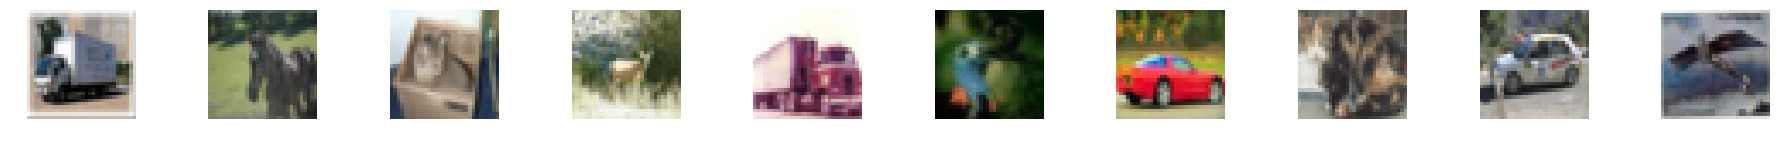

In [6]:
helper.show_images_simple(images)

### Build the network

In [7]:
dense_layer = partial(tf.layers.dense, activation=tf.nn.elu, 
                      kernel_initializer=tf.contrib.layers.variance_scaling_initializer())

inputs_ = tf.placeholder(tf.float32, (None, 32, 32, 3))

encoder = tf.layers.conv2d(inputs_, 12, [5, 5], strides=(1, 1), padding="SAME")
encoder = tf.layers.max_pooling2d(encoder, pool_size=(2, 2), strides=(2, 2), padding="SAME")
encoder = tf.layers.conv2d(encoder, 48, [5, 5], strides=(1, 1), padding="SAME")
encoder = tf.layers.max_pooling2d(encoder, pool_size=(2, 2), strides=(2, 2), padding="SAME")
encoder = tf.layers.conv2d(encoder, 192, [5, 5], strides=(4, 4), padding="SAME")

flattened = tf.contrib.layers.flatten(encoder)

hidden = dense_layer(flattened, 512)
hidden = dense_layer(hidden, 512)
hidden_mean = dense_layer(hidden, 20, activation=None)
hidden_gamma = dense_layer(hidden, 20, activation=None)
noise = tf.random_normal(tf.shape(hidden_gamma), dtype=tf.float32)
hidden_output = hidden_mean + tf.exp(0.5 * hidden_gamma) * noise
hidden = dense_layer(hidden_output, 512)
hidden = dense_layer(hidden, 512)

logits = dense_layer(hidden, 32 * 32 * 3, activation=None)
outputs = tf.sigmoid(logits)

xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.contrib.layers.flatten(inputs_), logits=logits)
reconstruction_loss = tf.reduce_sum(xentropy)
latent_loss = 0.5 * tf.reduce_sum(tf.exp(hidden_gamma) + tf.square(hidden_mean) - 1 - hidden_gamma)
loss = reconstruction_loss + latent_loss

training_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)

### Train the network

In [8]:
sess = tf.Session()

Training...
('Epoch: 1/500...', 'Training loss: 1993121.2500', 'Reconstruction loss: 1958643.8750', 'Latent loss: 34477.3125')
('Epoch: 2/500...', 'Training loss: 1925287.2500', 'Reconstruction loss: 1895351.5000', 'Latent loss: 29935.7891')
('Epoch: 3/500...', 'Training loss: 1894370.0000', 'Reconstruction loss: 1862121.3750', 'Latent loss: 32248.5645')
('Epoch: 4/500...', 'Training loss: 1882283.3750', 'Reconstruction loss: 1849272.2500', 'Latent loss: 33011.0859')
('Epoch: 5/500...', 'Training loss: 1873168.1250', 'Reconstruction loss: 1838588.1250', 'Latent loss: 34580.0000')
('Epoch: 6/500...', 'Training loss: 1865763.8750', 'Reconstruction loss: 1831004.2500', 'Latent loss: 34759.6641')
('Epoch: 7/500...', 'Training loss: 1860977.8750', 'Reconstruction loss: 1825433.3750', 'Latent loss: 35544.4883')
('Epoch: 8/500...', 'Training loss: 1857540.8750', 'Reconstruction loss: 1821993.5000', 'Latent loss: 35547.3281')
('Epoch: 9/500...', 'Training loss: 1854492.6250', 'Reconstruction l

('Epoch: 72/500...', 'Training loss: 1828235.1250', 'Reconstruction loss: 1799084.3750', 'Latent loss: 29150.7793')
('Epoch: 73/500...', 'Training loss: 1828288.2500', 'Reconstruction loss: 1799122.3750', 'Latent loss: 29165.8281')
('Epoch: 74/500...', 'Training loss: 1827817.8750', 'Reconstruction loss: 1798480.1250', 'Latent loss: 29337.7246')
('Epoch: 75/500...', 'Training loss: 1828162.7500', 'Reconstruction loss: 1799189.0000', 'Latent loss: 28973.7617')
('Epoch: 76/500...', 'Training loss: 1827654.8750', 'Reconstruction loss: 1798728.7500', 'Latent loss: 28926.1035')
('Epoch: 77/500...', 'Training loss: 1827416.5000', 'Reconstruction loss: 1798536.7500', 'Latent loss: 28879.8027')
('Epoch: 78/500...', 'Training loss: 1828479.1250', 'Reconstruction loss: 1799644.0000', 'Latent loss: 28835.0723')
('Epoch: 79/500...', 'Training loss: 1827400.2500', 'Reconstruction loss: 1798263.2500', 'Latent loss: 29136.9824')
('Epoch: 80/500...', 'Training loss: 1827828.6250', 'Reconstruction loss

('Epoch: 143/500...', 'Training loss: 1823736.2500', 'Reconstruction loss: 1794587.2500', 'Latent loss: 29148.9727')
('Epoch: 144/500...', 'Training loss: 1824041.6250', 'Reconstruction loss: 1794435.8750', 'Latent loss: 29605.7090')
('Epoch: 145/500...', 'Training loss: 1822838.5000', 'Reconstruction loss: 1793468.1250', 'Latent loss: 29370.3184')
('Epoch: 146/500...', 'Training loss: 1823086.2500', 'Reconstruction loss: 1793714.0000', 'Latent loss: 29372.3105')
('Epoch: 147/500...', 'Training loss: 1825561.0000', 'Reconstruction loss: 1795897.2500', 'Latent loss: 29663.7324')
('Epoch: 148/500...', 'Training loss: 1823114.2500', 'Reconstruction loss: 1793895.1250', 'Latent loss: 29219.1543')
('Epoch: 149/500...', 'Training loss: 1822825.8750', 'Reconstruction loss: 1793393.6250', 'Latent loss: 29432.3105')
('Epoch: 150/500...', 'Training loss: 1822795.5000', 'Reconstruction loss: 1793833.0000', 'Latent loss: 28962.4844')
('Epoch: 151/500...', 'Training loss: 1823040.3750', 'Reconstruc

('Epoch: 214/500...', 'Training loss: 1820321.1250', 'Reconstruction loss: 1790553.0000', 'Latent loss: 29768.1836')
('Epoch: 215/500...', 'Training loss: 1820052.8750', 'Reconstruction loss: 1790408.7500', 'Latent loss: 29644.1543')
('Epoch: 216/500...', 'Training loss: 1820233.3750', 'Reconstruction loss: 1790499.3750', 'Latent loss: 29734.0078')
('Epoch: 217/500...', 'Training loss: 1820022.8750', 'Reconstruction loss: 1790541.7500', 'Latent loss: 29481.0723')
('Epoch: 218/500...', 'Training loss: 1820309.5000', 'Reconstruction loss: 1790601.6250', 'Latent loss: 29707.9316')
('Epoch: 219/500...', 'Training loss: 1820802.6250', 'Reconstruction loss: 1791318.8750', 'Latent loss: 29483.8105')
('Epoch: 220/500...', 'Training loss: 1820381.7500', 'Reconstruction loss: 1790560.6250', 'Latent loss: 29821.0742')
('Epoch: 221/500...', 'Training loss: 1820178.6250', 'Reconstruction loss: 1790464.1250', 'Latent loss: 29714.5000')
('Epoch: 222/500...', 'Training loss: 1820131.1250', 'Reconstruc

('Epoch: 285/500...', 'Training loss: 1818271.0000', 'Reconstruction loss: 1787694.8750', 'Latent loss: 30576.0742')
('Epoch: 286/500...', 'Training loss: 1818631.6250', 'Reconstruction loss: 1788338.6250', 'Latent loss: 30293.0137')
('Epoch: 287/500...', 'Training loss: 1818242.7500', 'Reconstruction loss: 1788305.5000', 'Latent loss: 29937.2402')
('Epoch: 288/500...', 'Training loss: 1817973.7500', 'Reconstruction loss: 1787794.3750', 'Latent loss: 30179.4199')
('Epoch: 289/500...', 'Training loss: 1818702.2500', 'Reconstruction loss: 1788326.3750', 'Latent loss: 30375.9141')
('Epoch: 290/500...', 'Training loss: 1819220.8750', 'Reconstruction loss: 1788765.7500', 'Latent loss: 30455.1035')
('Epoch: 291/500...', 'Training loss: 1819493.7500', 'Reconstruction loss: 1789071.8750', 'Latent loss: 30421.8633')
('Epoch: 292/500...', 'Training loss: 1818112.2500', 'Reconstruction loss: 1788075.3750', 'Latent loss: 30036.8477')
('Epoch: 293/500...', 'Training loss: 1819093.8750', 'Reconstruc

('Epoch: 356/500...', 'Training loss: 1817156.1250', 'Reconstruction loss: 1786925.6250', 'Latent loss: 30230.4863')
('Epoch: 357/500...', 'Training loss: 1816921.6250', 'Reconstruction loss: 1786463.3750', 'Latent loss: 30458.2773')
('Epoch: 358/500...', 'Training loss: 1817756.5000', 'Reconstruction loss: 1786975.8750', 'Latent loss: 30780.6250')
('Epoch: 359/500...', 'Training loss: 1818114.6250', 'Reconstruction loss: 1787198.3750', 'Latent loss: 30916.2773')
('Epoch: 360/500...', 'Training loss: 1818539.6250', 'Reconstruction loss: 1787558.1250', 'Latent loss: 30981.5137')
('Epoch: 361/500...', 'Training loss: 1818152.8750', 'Reconstruction loss: 1787246.1250', 'Latent loss: 30906.7773')
('Epoch: 362/500...', 'Training loss: 1817673.0000', 'Reconstruction loss: 1787220.1250', 'Latent loss: 30452.8438')
('Epoch: 363/500...', 'Training loss: 1818944.7500', 'Reconstruction loss: 1787564.0000', 'Latent loss: 31380.7500')
('Epoch: 364/500...', 'Training loss: 1817371.7500', 'Reconstruc

('Epoch: 427/500...', 'Training loss: 1815254.6250', 'Reconstruction loss: 1784799.5000', 'Latent loss: 30455.1348')
('Epoch: 428/500...', 'Training loss: 1815577.1250', 'Reconstruction loss: 1785104.3750', 'Latent loss: 30472.7012')
('Epoch: 429/500...', 'Training loss: 1815573.1250', 'Reconstruction loss: 1785169.1250', 'Latent loss: 30404.0254')
('Epoch: 430/500...', 'Training loss: 1815218.2500', 'Reconstruction loss: 1784781.7500', 'Latent loss: 30436.4551')
('Epoch: 431/500...', 'Training loss: 1815604.0000', 'Reconstruction loss: 1784971.5000', 'Latent loss: 30632.5078')
('Epoch: 432/500...', 'Training loss: 1815281.0000', 'Reconstruction loss: 1785023.8750', 'Latent loss: 30257.1152')
('Epoch: 433/500...', 'Training loss: 1815788.5000', 'Reconstruction loss: 1785038.2500', 'Latent loss: 30750.1992')
('Epoch: 434/500...', 'Training loss: 1815819.2500', 'Reconstruction loss: 1785017.3750', 'Latent loss: 30801.8770')
('Epoch: 435/500...', 'Training loss: 1815509.0000', 'Reconstruc

('Epoch: 498/500...', 'Training loss: 1815111.7500', 'Reconstruction loss: 1784106.5000', 'Latent loss: 31005.2500')
('Epoch: 499/500...', 'Training loss: 1816006.0000', 'Reconstruction loss: 1785053.5000', 'Latent loss: 30952.5605')
('Epoch: 500/500...', 'Training loss: 1814947.7500', 'Reconstruction loss: 1783937.2500', 'Latent loss: 31010.4922')


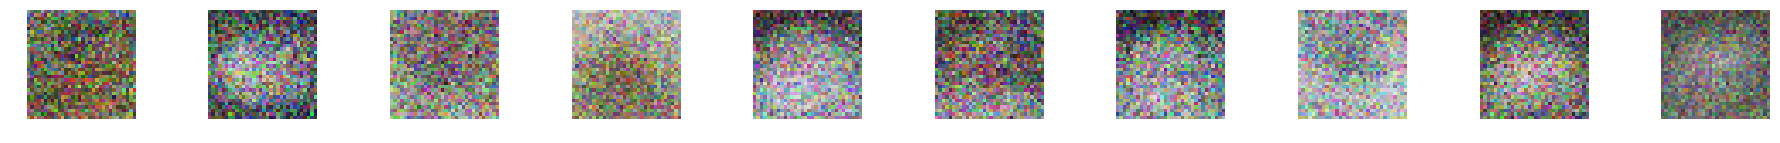

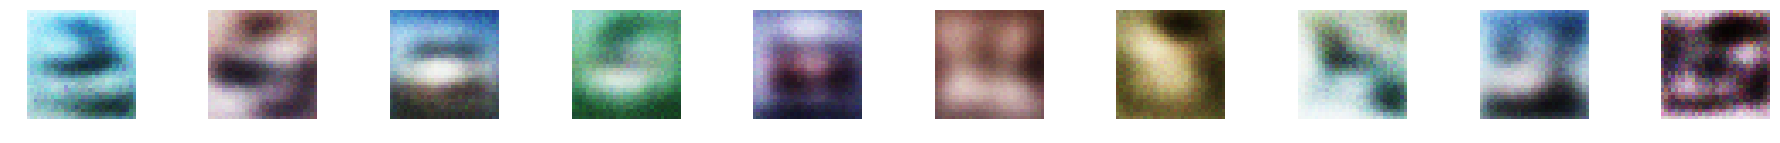

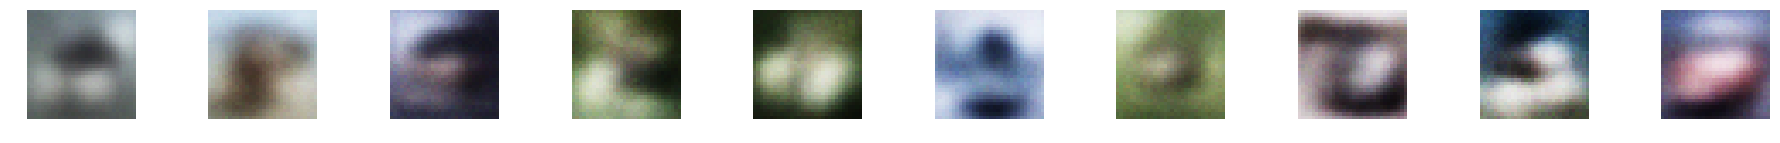

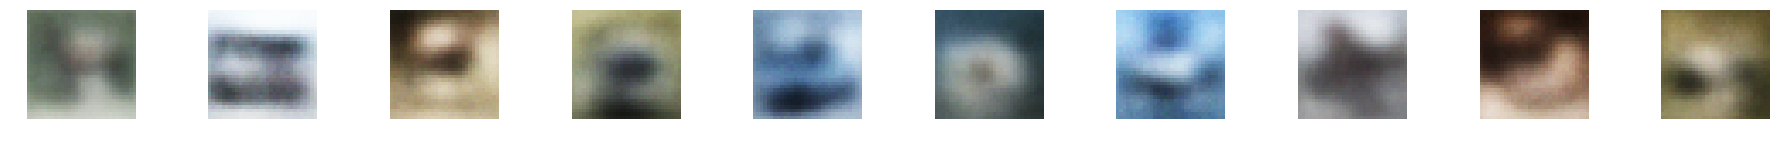

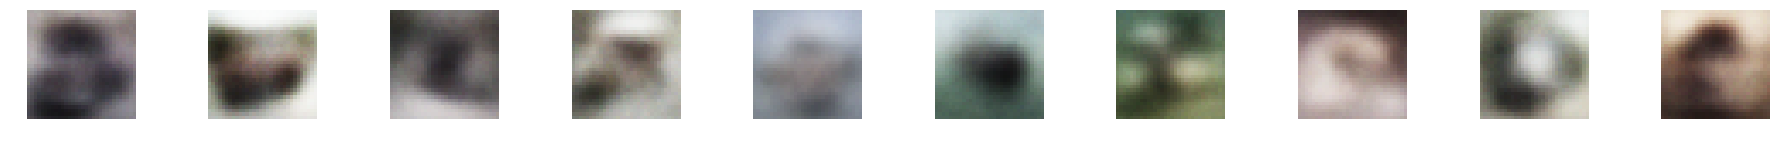

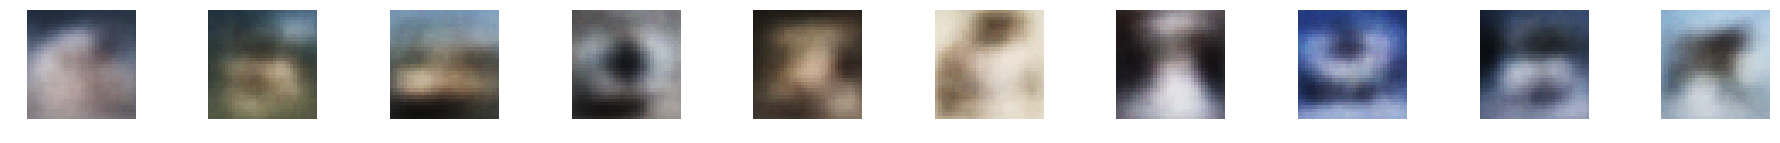

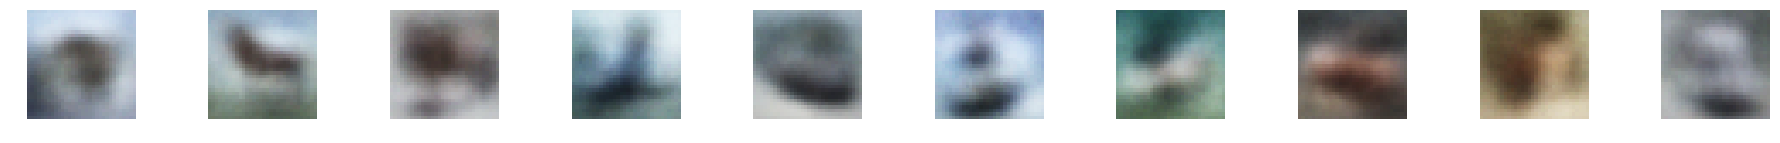

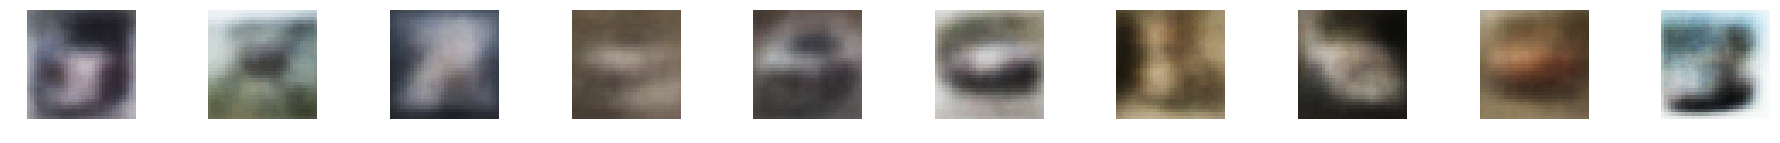

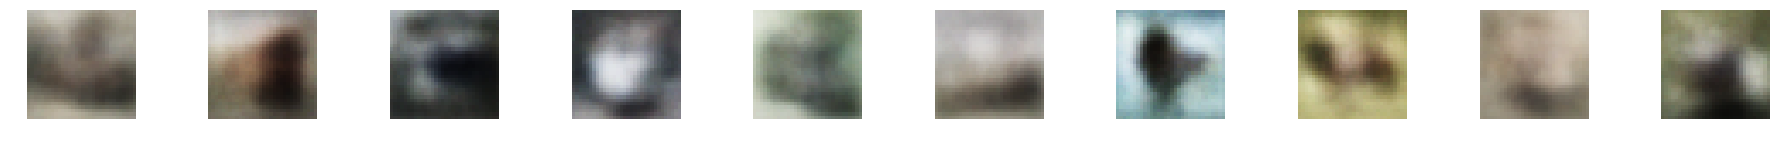

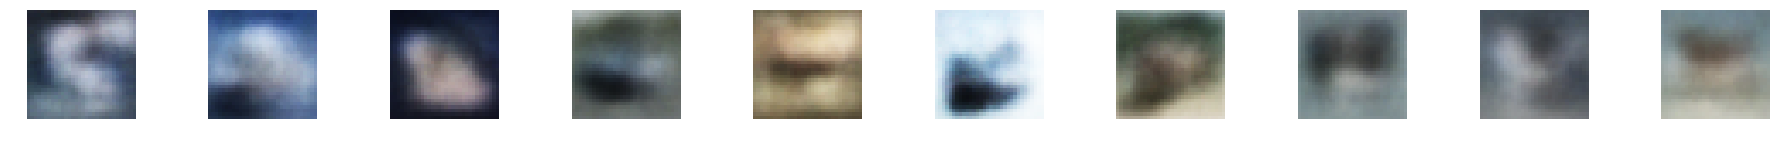

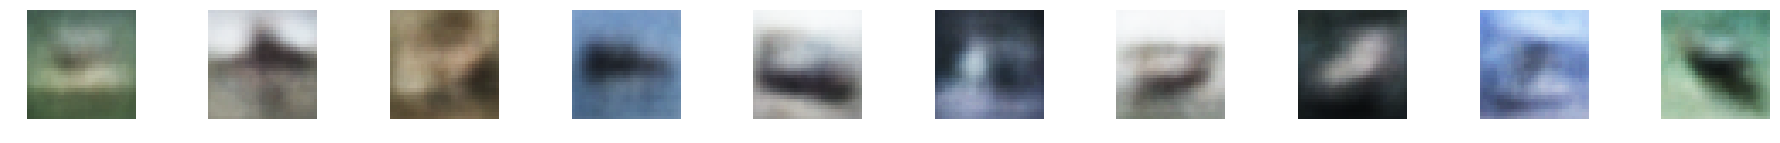

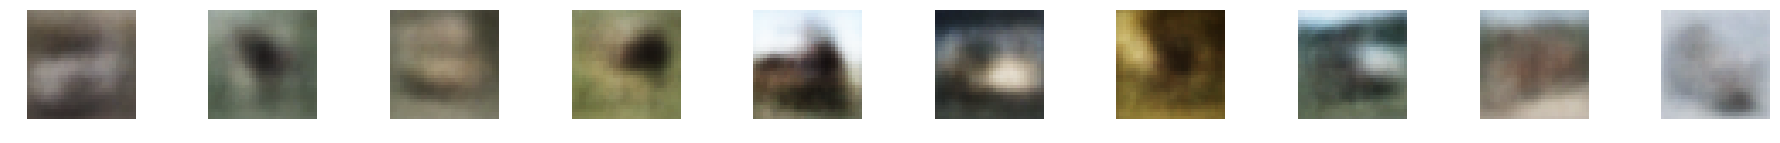

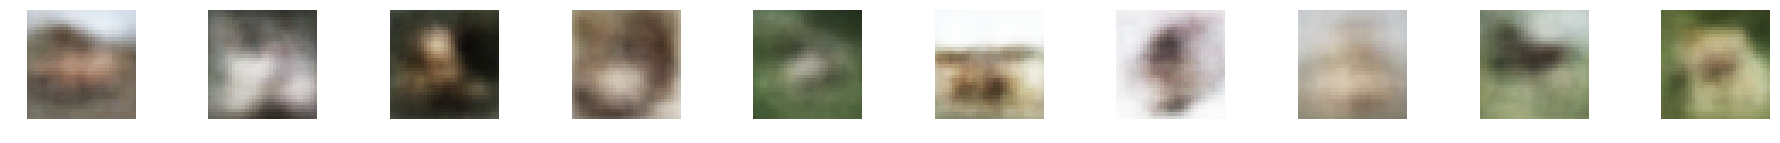

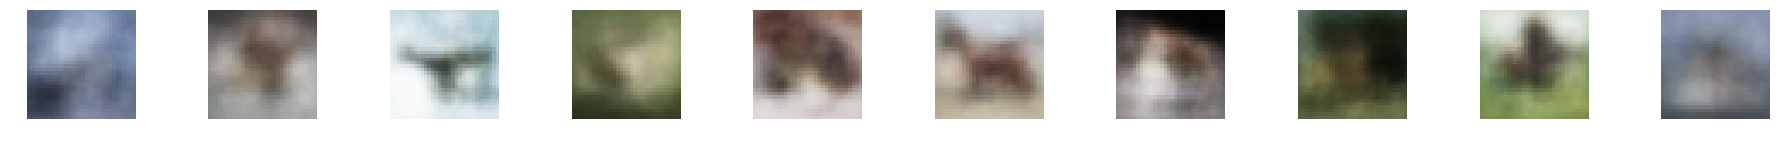

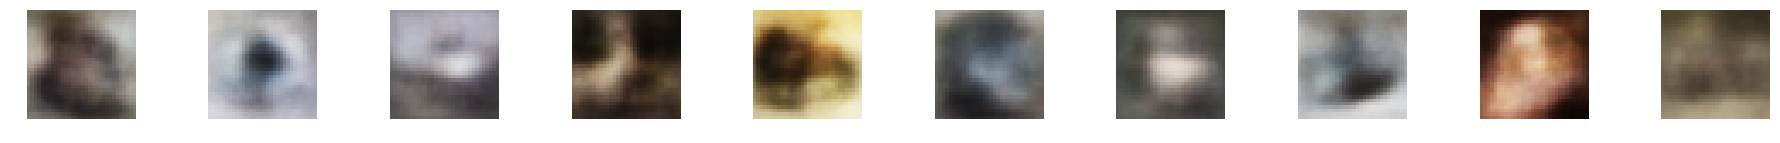

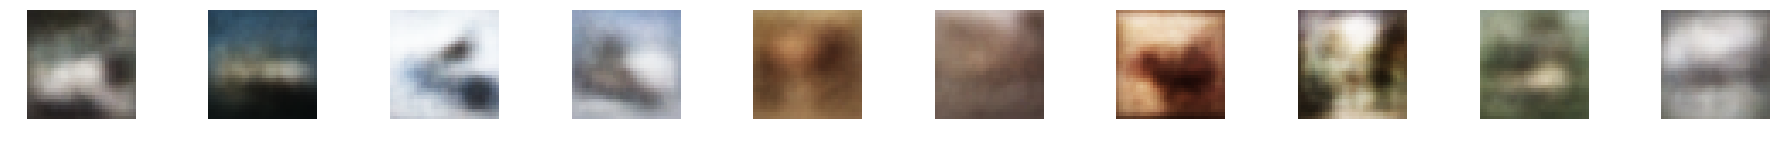

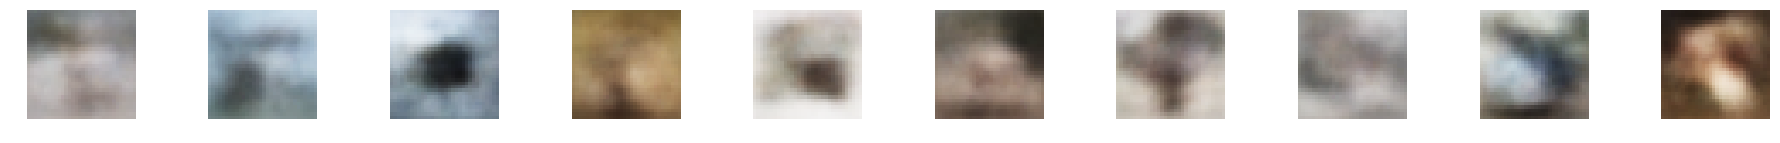

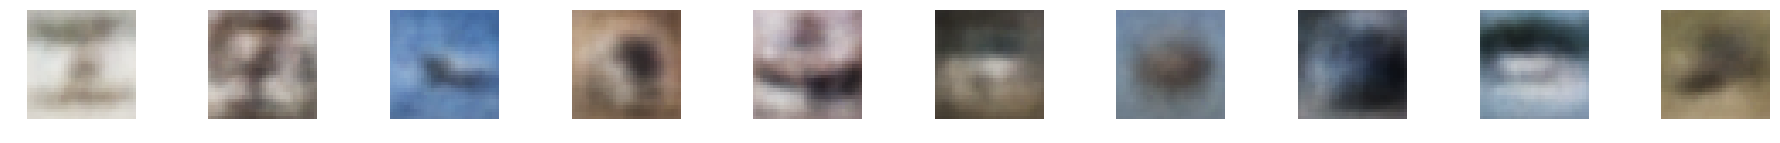

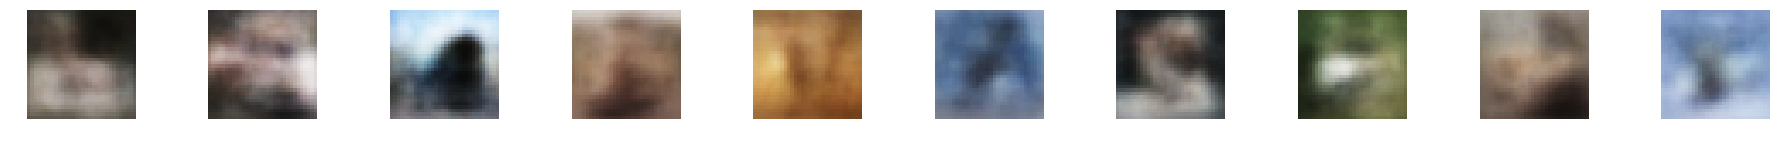

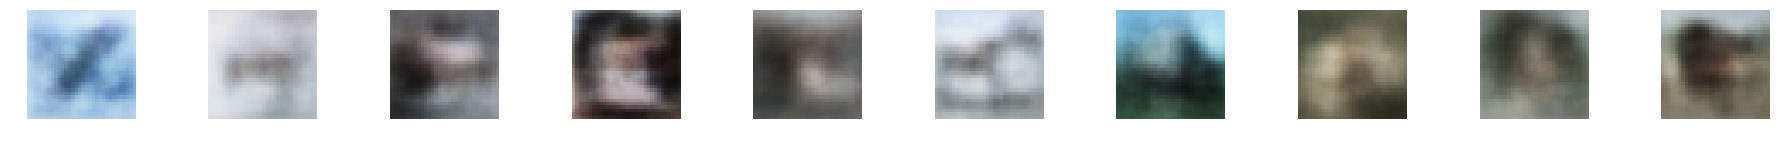

In [9]:
print('Training...')

sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for batch_i in range(1, N_BATCHES + 1):
        for features, _, _ in helper.load_preprocess_training_batch(batch_i, batch_size):
            sess.run(training_op, feed_dict={inputs_: features})
    loss_val, reconstruction_loss_val, latent_loss_val = sess.run([loss, reconstruction_loss, latent_loss], 
                                                                  feed_dict={inputs_: features})
    print("Epoch: {}/{}...".format(e + 1, epochs), 
          "Training loss: {:.4f}".format(loss_val), 
          "Reconstruction loss: {:.4f}".format(reconstruction_loss_val), 
          "Latent loss: {:.4f}".format(latent_loss_val))
    if e % show_images_every_n_epochs == 0:
        outputs_val = outputs.eval(session=sess, feed_dict={hidden_output: np.random.normal(size=[10, 20])})
        helper.show_images_simple(outputs_val, False)

### Test the network

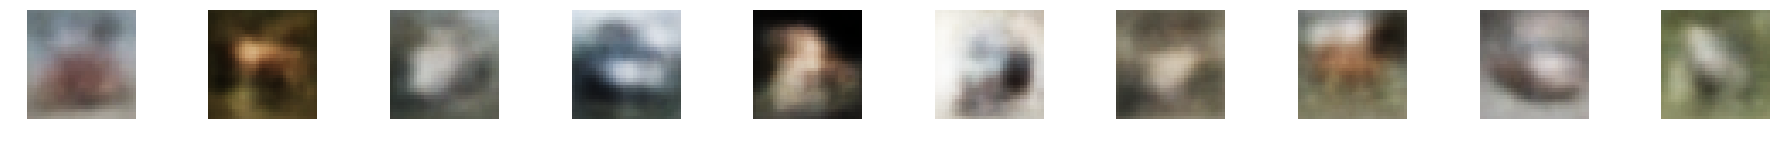

In [10]:
outputs_val = outputs.eval(session=sess, feed_dict={hidden_output: np.random.normal(size=[10, 20])})
helper.show_images_simple(outputs_val, False)